In [20]:
import torch
import torch.nn
import numpy
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# 张量

In [14]:
a = torch.randn((3, 2))

In [15]:
a

tensor([[-0.0538, -0.5265],
        [-0.6037, -1.6397],
        [-0.3549, -0.1846]])

In [12]:
torch.chunk(a, 3)

(tensor([[ 0.0977, -0.4849]]),
 tensor([[-0.4176,  0.6844]]),
 tensor([[ 0.0023, -0.6948]]))

In [13]:
torch.reshape(a, (-1,))

tensor([ 0.0977, -0.4849, -0.4176,  0.6844,  0.0023, -0.6948])

In [18]:
torch.squeeze(torch.reshape(a, [3, 1, 2, 1, 1]), dim=1)

tensor([[[[-0.0538]],

         [[-0.5265]]],


        [[[-0.6037]],

         [[-1.6397]]],


        [[[-0.3549]],

         [[-0.1846]]]])

In [21]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100.6%


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100.0%


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



119.3%

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



# 数据集数据可视化

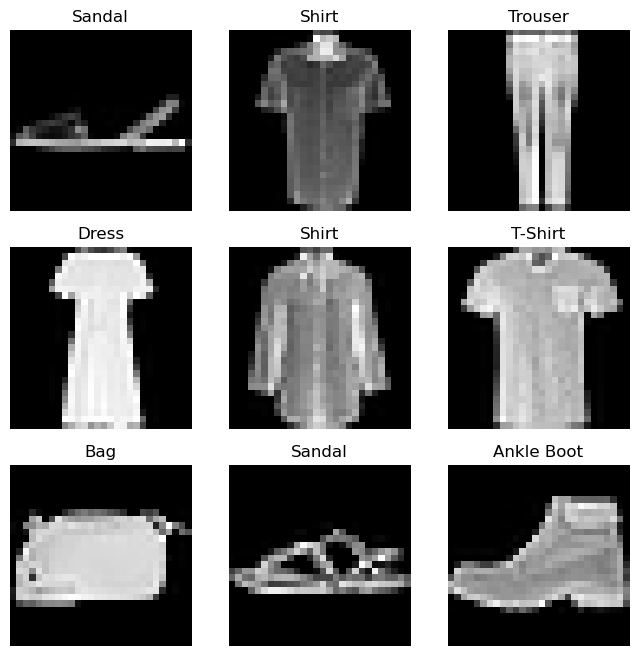

In [22]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# 创建属于自己的数据集

In [23]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [25]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


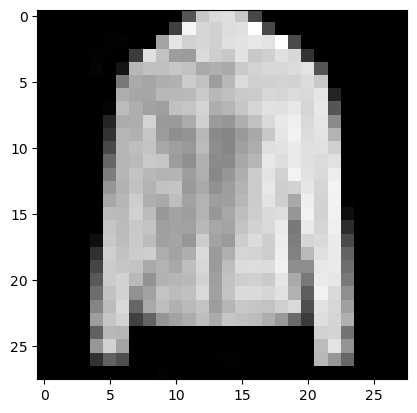

Label: 4


In [28]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# 分类网络示例

In [29]:
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor, Lambda

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [31]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [32]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [35]:
x = torch.rand(1, 28, 28, device=device)
logits = model(x)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([1], device='cuda:0')


In [34]:
pred_probab

tensor([[0.0929, 0.1129, 0.0984, 0.0975, 0.0972, 0.0982, 0.1011, 0.0977, 0.1060,
         0.0981]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [36]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


In [37]:
flatten = nn.Flatten()
flatten_image = flatten(input_image)
print(flatten_image.size())

torch.Size([3, 784])


In [38]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flatten_image)
print(hidden1.size())

torch.Size([3, 20])


In [39]:
print(f'hidden1: {hidden1}')
hidden1 = nn.ReLU()(hidden1)
print(f'hidden1: {hidden1}')

hidden1: tensor([[-0.0630,  0.4420,  0.4890, -0.1765,  0.3223, -0.0367, -0.4144, -0.0569,
         -0.5394,  0.4377,  0.3280,  0.0489, -0.3583,  0.6108,  0.0637, -0.6065,
         -0.0743,  0.1212,  0.1418,  0.2534],
        [-0.2722,  0.2191,  0.2552, -0.1172,  0.5691, -0.4308, -0.6790, -0.0118,
         -0.5456,  0.4357,  0.0477, -0.5355,  0.1412,  0.4549,  0.3583, -0.0502,
          0.1497,  0.1852,  0.1647, -0.0062],
        [-0.2489,  0.6318,  0.7392, -0.2406,  0.1495, -0.3719, -0.6075,  0.0027,
         -0.4056,  0.3366, -0.0923, -0.2681, -0.1016,  0.9446, -0.1019, -0.3732,
          0.0658, -0.0685, -0.1269,  0.0211]], grad_fn=<AddmmBackward0>)
hidden1: tensor([[0.0000, 0.4420, 0.4890, 0.0000, 0.3223, 0.0000, 0.0000, 0.0000, 0.0000,
         0.4377, 0.3280, 0.0489, 0.0000, 0.6108, 0.0637, 0.0000, 0.0000, 0.1212,
         0.1418, 0.2534],
        [0.0000, 0.2191, 0.2552, 0.0000, 0.5691, 0.0000, 0.0000, 0.0000, 0.0000,
         0.4357, 0.0477, 0.0000, 0.1412, 0.4549, 0.3583, 0.000

In [40]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

In [41]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [42]:
print(f"Model structure: {model}\n\n")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0062, -0.0273,  0.0201,  ..., -0.0056, -0.0224,  0.0147],
        [-0.0125,  0.0326,  0.0185,  ...,  0.0034, -0.0265, -0.0232]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0134,  0.0037], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0327, -0.0037, -0.0153,  ..., -0.0273,  0.0321, -0.0377],
        [ 0.0408, -0.0317,  0.0280,  ...,  0.0123,  0.0132,  0.0218]],
       device='cuda:0', grad_fn=<Sl

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [44]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20)
        self.conv2 = nn.Conv2d(20, 20)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))

In [46]:
@ torch.no_grad()
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.fill_(1.0)
        m.bias.fill_(0.0)

net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
net.apply(init_weights)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
)

In [47]:
import torchvision.models as models

model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


In [48]:
model = models.vgg16()
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [54]:
model.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3

# autograd

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = F.binary_cross_entropy_with_logits(z, y)
loss

tensor(0.4574, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [56]:
print('Gradient function for z =', z.grad_fn)
print('Gradient function for loss =', loss.grad_fn)

Gradient function for z = <AddBackward0 object at 0x0000026F914D1F40>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x0000026F914D1C40>


In [57]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1957, 0.1181, 0.0163],
        [0.1957, 0.1181, 0.0163],
        [0.1957, 0.1181, 0.0163],
        [0.1957, 0.1181, 0.0163],
        [0.1957, 0.1181, 0.0163]])
tensor([0.1957, 0.1181, 0.0163])


In [59]:
# 梯度累加
inp = torch.eye(5, requires_grad=True)
out = (inp + 1) ** 2
out.backward(torch.ones_like(inp), retain_graph=True)
print('First call\n', inp.grad)
out.backward(torch.ones_like(inp), retain_graph=True)
print('\nSecond call\n', inp.grad)
inp.grad.zero_()
out.backward(torch.ones_like(inp), retain_graph=True)
print('\nCall after zeroing gradients\n', inp.grad)

First call
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])

Second call
 tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.],
        [4., 4., 4., 4., 8.]])

Call after zeroing gradients
 tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.],
        [2., 2., 2., 2., 4.]])
